# 0. Extract from MXL

In [1]:
import zipfile
import glob

filename = "../../XMLs/jinglebells.xml"
with zipfile.ZipFile(filename, 'r') as zipfile:
    zipfile.extractall('jinglebells.musicxml')

BadZipFile: File is not a zip file

# 1. Read XML

In [66]:
import xml.etree.cElementTree as ET

filename = "../../XMLs/至少還有你_主旋律.musicxml"
#filename = "../../XMLs/jinglebells.xml"
tree = ET.parse(filename)

In [67]:
root = tree.getroot()
root.tag, root.attrib

('score-partwise', {'version': '3.1'})

In [68]:
all_notes = root.findall('.//note')

In [69]:
lyric_notes = []
for note in all_notes:
    n = {}
    if note.find('lyric') is not None:
        n['type'] = note.find('type').text
        n['lyric'] = note.find('./lyric/text').text
        n['pitch'] = note.find('./pitch/step').text + note.find('./pitch/octave').text
        if note.find('./pitch/alter') is not None:
            if note.find('./pitch/alter').text == '-1':
                p = n['pitch'][0] + 'b' + n['pitch'][1]
                n['pitch'] = p
            else:
                n['pitch'] = n['pitch'][0] + '#' + n['pitch'][1]
                
        lyric_notes.append(n)

In [70]:
len(lyric_notes)

159

In [71]:
lyric_notes

[{'type': '16th', 'lyric': '我', 'pitch': 'G4'},
 {'type': '16th', 'lyric': '怕', 'pitch': 'G4'},
 {'type': 'eighth', 'lyric': '來', 'pitch': 'F#4'},
 {'type': '16th', 'lyric': '不', 'pitch': 'A4'},
 {'type': '16th', 'lyric': '幾', 'pitch': 'D5'},
 {'type': '16th', 'lyric': '我', 'pitch': 'A4'},
 {'type': '16th', 'lyric': '要', 'pitch': 'A4'},
 {'type': 'eighth', 'lyric': '抱', 'pitch': 'D5'},
 {'type': '16th', 'lyric': '著', 'pitch': 'A4'},
 {'type': '16th', 'lyric': '你', 'pitch': 'B4'},
 {'type': '16th', 'lyric': '直', 'pitch': 'G4'},
 {'type': '16th', 'lyric': '到', 'pitch': 'G4'},
 {'type': 'eighth', 'lyric': '感', 'pitch': 'F#4'},
 {'type': 'eighth', 'lyric': '覺', 'pitch': 'A4'},
 {'type': 'eighth', 'lyric': '你', 'pitch': 'D5'},
 {'type': '16th', 'lyric': '的', 'pitch': 'E5'},
 {'type': '16th', 'lyric': '皺', 'pitch': 'E5'},
 {'type': 'eighth', 'lyric': '紋', 'pitch': 'D5'},
 {'type': '16th', 'lyric': '有', 'pitch': 'D5'},
 {'type': '16th', 'lyric': '了', 'pitch': 'E5'},
 {'type': 'eighth', 'lyric

# 2. Exploring 

In [72]:
time = root.find('.//time')

In [73]:
time.find(".//beats").text

'4'

In [74]:
time.find(".//beat-type").text

'4'

# 3. Helper classes /functions

## 3.1 Helper classes

In [11]:
from enum import Enum

class NoteTypes(Enum):
    '''Class defining types of notes'''
    whole = 1
    half = 2
    quarter = 4
    eight = 8
    sixteenth = 16
    thirtysecond = 32

In [12]:
class NoteLetters(Enum):
    C = 0
    D = 2
    E = 4
    F = 6
    G = 8
    A = 10
    B = 12

In [145]:
import math

class Note:
    '''Class representing a musical note'''
    notetype = None
    step = ''
    octave = 0
    so = None
    tie = None
    accidental = None
    dot = False
    
    def __init__(self,notetype,step,octave,tie,accidental,dot):
        self.notetype = notetype
        self.step = step
        self.octave = int(octave)
        self.tie = tie
        self.accidental = accidental
        self.dot = dot
        
    def get_so(self):
        if self.accidental:
            so = self.step + self.accidental + str(self.octave)
        else:
            
            so = self.step + str(self.octave)
        return so
    
    def printNote(self):
        if self.step=='':
            print('Note: ' + 'rest' + ' / ' +
              str(self.notetype))
        else:
            print('Note: ' + str(self.get_so()) + ' / ' +
              str(self.notetype) + ' / ' +
              str(self.tie)) 
            
    def addOctaves(self,addOct):
        self.octave += addOct
        
    def copyNote(self):
        ncopy = Note(self.notetype,self.step,self.octave,self.tie,self.accidental,self.dot)
        return ncopy
    
    def addSemiTones(self,semiTToAdd):
        
        #get relative position of new note
        newVal = getattr(NoteLetters,self.step).value + semiTToAdd
        #DEBUG
        #print(newVal)
        
        #handle semitones first
        if (semiTToAdd%2!=0):
            
            if self.accidental == '#':
                self.accidental = None
                newVal += 1

            elif self.accidental == 'b':
                self.accidental = None
                newVal -= 1
            
            elif not self.accidental:
                self.accidental = '#'
                newVal -= 1
                
            #natural, assumes sharps in score
            else:
                self.accidental = None
                newVal -= 1

       
        #Change step
        self.step = NoteLetters(newVal% 14).name
        
        #change octave
        self.octave += math.floor(newVal/14)   

        

In [146]:
class Measure:
    '''Class representing a measure'''
    notes = []
    
    def __init__(self,notes):
        self.notes = notes
    
    def get_sos(self):
        sos = []
        for note in self.notes:
            sos.append(note.get_so())
        return sos
    
    def get_notetypes(self):
        notetypes = []
        for note in self.notes:
            notetypes.append(note.notetype)
        return notetypes 
    
    def get_ties(self):
        ties = []
        for tie in self.notes:
            ties.append(note.tie)
        return ties 
    
    def printMeasure(self):
        for note in self.notes:
            note.printNote()
            
    def get_notes(self):
        return notes

## 3.2 Helper functions

In [147]:
def get_ts_xml(root):
    '''Gets time signature for a musicxml file.
    Input: Root of XML Tree
    Output:top and bottom numbers of the Time signature'''
    time = root.find('.//time')
    top = int(time.find(".//beats").text)
    bottom = int(time.find(".//beat-type").text)
    return top,bottom

In [97]:
get_ts_xml(root)

(4, 4)

In [98]:
def get_bpm_xml(root):
    '''Gets beats per minute as well as type of beats for a musicxml file.
    Input: Root of XML Tree
    Output: beats per minute, noteType'''
    metronome = root.find('.//metronome')
    beats_per_min = int(metronome.find('.//per-minute').text)
    beat_type = metronome.find('.//beat-unit').text
    #beat_type = getattr(NoteTypes, str(beat_type))
    return beats_per_min, beat_type

In [99]:
get_bpm_xml(root)

(62, 'quarter')

In [126]:
def decode_xml_note(xml_note):
    '''Gets note type, step, octave and tie type'''
    try:
        notetype = xml_note.find('.//type').text
    except:
        notetype = None
    try:
        step = xml_note.find('.//step').text
    except:
        step = ''
    try:
        octave = xml_note.find('.//octave').text
    except:
        octave = 0
    try:
        tie = xml_note.find('.//tie').get('type')
    except:
        tie = None
    if xml_note.find('.//dot') != None:
        dot = True
    else:
        dot = False
    try:
        accidental = xml_note.find('.//accidental').text
        if accidental == 'natural':
            accidental = 'n'
        if accidental == 'flat':
            accidental = 'b'
        if accidental == 'sharp':
            accidental = '#'
            
    except:
        accidental = None
        
    note = Note(notetype,step,octave,tie,accidental,dot)
    #DEBUG
    #note.printNote()
    
    return note

In [127]:
measures = root.findall('.//measure')
xml_measure_notes = measures[4].findall('.//note')
xml_note = xml_measure_notes[0]
decode_xml_note(xml_note)

In [128]:
def get_meas_notes_xml(xml_measure_notes):
    ''''return all notes in an xml measure'''
    notes = []
    for xml_note in xml_measure_notes:
        note = decode_xml_note(xml_note)
        if note.notetype:
            notes.append(note)
        #DEBUG
        #note.printNote()
    return notes

In [129]:
def compare_notes(n1,n2):
    '''returns the difference in semitones between 2 notes'''
    val1 = getattr(NoteLetters,n1.step).value
    val2 = getattr(NoteLetters,n2.step).value
    difference = val2 - val1
    #add octaves
    difference += (n2.octave - n1.octave) * 14
    #add accidentals
    if (n1.accidental):
        if n1.accidental == '#':
            difference-=1
        elif n1.accidental == 'b':
            difference+=1
        #naturals,assumes the sheet music has flat alterations only
        else:
            difference+=1
    if (n2.accidental):
        if n1.accidental == '#':
            difference+=1
        elif n1.accidental == 'b':
            difference-=1
        #naturals,assumes the sheet music has flat alterations only
        else:
            difference-=1
    return difference

In [173]:
def get_inverted_measure(measure):
    
    #get first note
    inv_notes = []
    prevNoteNew = measure.notes[0].copyNote()
    if prevNoteNew.step!= '':
        prevNoteNew.addSemiTones(-14)
    #DEBUG
    #prevNoteNew.printNote()
    inv_notes.append(prevNoteNew)
    prevNoteOg = measure.notes[0].copyNote()
    
    for nextNoteOg in measure.notes[1:]:
        #handle rests
        if nextNoteOg.step == '':
            nextNoteNew = nextNoteOg.copyNote()
        else:
             #if previous measure is a rest
            if prevNoteOg.step!='':
                nextNoteNew = Note(nextNoteOg.notetype,prevNoteNew.step,prevNoteNew.octave,nextNoteOg.tie,nextNoteOg.accidental,nextNoteOg.dot)
                diff = compare_notes(prevNoteOg,nextNoteOg)
            else:
                nextNoteNew = nextNoteOg.copyNote()
                diff = 14
            nextNoteNew.addSemiTones(-diff)
        inv_notes.append(nextNoteNew)
        prevNoteOg = nextNoteOg
        prevNoteNew = nextNoteNew
            #DEBUG 
            #print(diff)
            #prevNoteNew.printNote()

    inv_meas = Measure(inv_notes)
    return inv_meas
    

In [131]:
get_meas_notes_xml(xml_measure_notes)

## 3.3 Try to use classes

In [132]:
#get a note
xml_measures = root.findall('.//measure')
xml_measure = xml_measures[6].findall('.//note')
xml_note = xml_measure[0]
note = decode_xml_note(xml_note)
note.printNote()

Note: F4 / eighth / None


In [133]:
xml_note = xml_measure[6]
print(xml_note.find('.//dot'))

<Element 'dot' at 0x7f4e032d9b38>


In [134]:
xml_note.find('.//step').text

'D'

In [135]:
note.so

In [136]:
note.notetype

'eighth'

In [137]:
note.tie

In [138]:
#get a measure
measure = Measure(get_meas_notes_xml(xml_measure))
measure.printMeasure()

Note: F4 / eighth / None
Note: A4 / eighth / None
Note: D5 / eighth / None
Note: E5 / 16th / None
Note: E5 / 16th / start
Note: E5 / 16th / stop
Note: D5 / eighth / None
Note: rest / eighth
Note: D5 / 16th / None
Note: E5 / 16th / None


In [139]:
measure.get_sos()

['F4', 'A4', 'D5', 'E5', 'E5', 'E5', 'D5', '0', 'D5', 'E5']

In [140]:
measure.get_notetypes()

['eighth',
 'eighth',
 'eighth',
 '16th',
 '16th',
 '16th',
 'eighth',
 'eighth',
 '16th',
 '16th']

In [141]:
measure.get_ties()

[None, None, None, None, None, None, None, None, None, None]

In [149]:
#read all measures
xml_measures = root.findall('.//measure')
measures = []

for xml_measure in xml_measures:
    measure = Measure(get_meas_notes_xml(xml_measure))
    if not measure.get_sos()==['0']:
        measures.append(measure)

In [150]:
#try adding semitones
n1 = measures[1].notes[1]
n1.printNote()
n2 = n1.copyNote()
n2.printNote()

Note: A4 / 16th / None
Note: A4 / 16th / None


## 3.4 Add/remove semitones and compare notes

In [151]:
#new note at the nottom, lower by 2 semitones
n3 = Note('quarter','B','4',None,None,False)
n3.printNote()
newval = getattr(NoteLetters,n3.step).value+2
newval

Note: B4 / quarter / None


14

In [152]:
NoteLetters(newval%14)

<NoteLetters.C: 0>

In [153]:
NoteLetters(newval%14).name

'C'

In [157]:
#try the function
n4 = Note('quarter','B','4',None,None,False)
n4.addSemiTones(-2)
n4.printNote()

Note: A4 / quarter / None


In [158]:
#try the function
n4 = Note('quarter','B','4',None,None,False)
n4.addSemiTones(2)
n4.printNote()

Note: C5 / quarter / None


## 3.5 Compare 2 notes

In [159]:
#1st try
n1 = Note('quarter','B','4',None,None,False)
n2 = Note('quarter','D','4',None,None,False)
n3 = n1.copyNote()

In [160]:
diff = compare_notes(n1,n2)
diff

-10

In [161]:
n3.addSemiTones(-diff)
n3.printNote()

Note: G5 / quarter / None


In [165]:
#2nd try
n1 = Note('quarter','D','3',None,None,False)
n2 = Note('quarter','A','5',None,None,False)
n3 = n1.copyNote()
n1.printNote()

Note: D3 / quarter / None


In [166]:
diff = compare_notes(n1,n2)
diff

36

In [167]:
n3.addSemiTones(diff)
n3.printNote()

Note: A5 / quarter / None


# 3.6 invert notes

In [168]:
#use function
m1 = measures[4]

In [169]:
m1.printMeasure()

Note: F5 / eighth / None
Note: C5 / 16th / None
Note: C5 / 16th / start
Note: C5 / eighth / stop
Note: B4 / eighth / None
Note: C5 / quarter / None
Note: A4 / 16th / None
Note: A4 / 16th / None


In [174]:
inv_m2 = None
inv_m2 = get_inverted_measure(m1)
inv_m2.printMeasure()

Note: F4 / eighth / None
Note: B4 / 16th / None
Note: B4 / 16th / start
Note: B4 / eighth / stop
Note: C5 / eighth / None
Note: B4 / quarter / None
Note: D5 / 16th / None
Note: D5 / 16th / None


In [175]:
inv_m2 = get_inverted_measure(measures[0])
inv_m2.printMeasure()

Note: rest / half
Note: rest / quarter
Note: rest / eighth
Note: G3 / 16th / None
Note: G3 / 16th / None


In [176]:
compare_notes(measures[4].notes[0],measures[4].notes[1])

-6

In [177]:
i=0
for measure in measures:
    inv_meas = get_inverted_measure(measure)
    print(i)
    i+=1
    inv_meas.printMeasure()

0
Note: rest / half
Note: rest / quarter
Note: rest / eighth
Note: G3 / 16th / None
Note: G3 / 16th / None
1
Note: F3 / eighth / None
Note: D3 / 16th / None
Note: A2 / 16th / start
Note: A2 / half / stop
Note: A2 / eighth / stop
Note: D3 / 16th / None
Note: D3 / 16th / None
2
Note: D4 / eighth / None
Note: G4 / 16th / None
Note: F4 / 16th / start
Note: F4 / half / stop
Note: F4 / eighth / stop
Note: A4 / 16th / None
Note: A4 / 16th / None
3
Note: F3 / eighth / None
Note: D3 / eighth / None
Note: A2 / eighth / None
Note: G2 / 16th / None
Note: G2 / 16th / start
Note: G2 / 16th / stop
Note: A2 / eighth / None
Note: rest / eighth
Note: D4 / 16th / None
Note: C4 / 16th / None
4
Note: F4 / eighth / None
Note: B4 / 16th / None
Note: B4 / 16th / start
Note: B4 / eighth / stop
Note: C5 / eighth / None
Note: B4 / quarter / None
Note: D5 / 16th / None
Note: D5 / 16th / None
5
Note: B3 / eighth / None
Note: G3 / eighth / None
Note: G3 / eighth / None
Note: B3 / 16th / None
Note: F3 / 16th / start

In [178]:
measures[18].printMeasure()

Note: F5 / eighth / None
Note: E5 / 16th / None
Note: E5 / 16th / start
Note: E5 / eighth / stop
Note: E5 / 16th / None
Note: D5 / 16th / None
Note: E5 / 16th / None
Note: E5 / 16th / None
Note: A5 / eighth / None
Note: A5 / eighth / None
Note: A4 / 16th / None
Note: A4 / 16th / None


# 4. Read XML and get measures to invert chords

In [179]:
xml_measures = root.findall('.//measure')
measures = []

for xml_measure in xml_measures:
    measure = Measure(get_meas_notes_xml(xml_measure))
    measures.append(measure)
    

In [180]:
for measure in measures:
    measure.printMeasure()

Note: rest / whole
Note: rest / whole
Note: rest / whole
Note: rest / half
Note: rest / quarter
Note: rest / eighth
Note: G4 / 16th / None
Note: G4 / 16th / None
Note: F4 / eighth / None
Note: A4 / 16th / None
Note: D5 / 16th / start
Note: D5 / half / stop
Note: D5 / eighth / stop
Note: A4 / 16th / None
Note: A4 / 16th / None
Note: D5 / eighth / None
Note: A4 / 16th / None
Note: B4 / 16th / start
Note: B4 / half / stop
Note: B4 / eighth / stop
Note: G4 / 16th / None
Note: G4 / 16th / None
Note: F4 / eighth / None
Note: A4 / eighth / None
Note: D5 / eighth / None
Note: E5 / 16th / None
Note: E5 / 16th / start
Note: E5 / 16th / stop
Note: D5 / eighth / None
Note: rest / eighth
Note: D5 / 16th / None
Note: E5 / 16th / None
Note: F5 / eighth / None
Note: C5 / 16th / None
Note: C5 / 16th / start
Note: C5 / eighth / stop
Note: B4 / eighth / None
Note: C5 / quarter / None
Note: A4 / 16th / None
Note: A4 / 16th / None
Note: B4 / eighth / None
Note: D5 / eighth / None
Note: D5 / eighth / None
N

# 6. Build music21

In [275]:
def measures_to_m21Part(measures):
    '''Builds a Score in m21 format from array of Measure types'''
    
    score = None
    score = stream.Part()

    for measure in measures:
        measure_notes = measure.notes
        s1 = stream.Measure()
        
        #add ts to first measure
        #if not score:
            #s1.timeSignature = ts
        
        for n in measure_notes:
            #handle rests
            if n.step == '':
                s1.append(note.Rest(type=n.notetype))
            #notes
            else:
                m21Note = note.Note(n.get_so(),type=n.notetype, dots=n.dot)
                if n.tie:
                    m21Note.tie = tie.Tie(n.tie)
                
                s1.append(m21Note)
        score.append(s1)
        
    return score

def build_m21Score_1p(part1,title,ts):
    '''builds a m21 score from 1 part'''
    clef1 = m21.clef.TrebleClef()
    clef1.offset = 0.0
    part1.offset = 0.0
    part1.id = 'mainPart'
    score = m21.stream.Score([clef1, part1])
    score.insert(0, metadata.Metadata())
    score.metadata.title = title
    score.timeSignature = ts
    #s2.duration.quarterLength

    return score

def build_m21Score_2p(part1,part2,title,ts):
    '''builds a m21 score from 2 parts'''
    clef1 = m21.clef.TrebleClef()
    clef1.offset = 0.0
    part1.offset = 0.0
    part1.id = 'mainPart'

    clef2 = m21.clef.BassClef()
    clef2.offset = 0.0
    part2.offset = 0.0
    part2.id = 'accPart'

    score = m21.stream.Score([clef1, part1, clef2, part2])
    score = m21.stream.Score([clef1, part1])
    score.insert(0, metadata.Metadata())
    score.metadata.title = title
    score.timeSignature = ts
    
    #s2.duration.quarterLength

    return score

In [264]:
s1 = stream.Measure()
dir(s1)

['_DOC_ATTR',
 '_DOC_ORDER',
 '__add__',
 '__bool__',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_accumulatedSeconds',
 '_activeSite',
 '_activeSiteStoredOffset',
 '_atSoundingPitch',
 '_cache',
 '_classListFullyQualifiedCacheDict',
 '_classSetCacheDict',
 '_classTupleCacheDict',
 '_consolidateLayering',
 '_deepcopySubclassable',
 '_derivation',
 '_durSpanOverlap',
 '_duration',
 '_editorial',
 '_elements',
 '_endElements',
 '_findLayering',
 '_fixMeasureNumbers',
 '_getActiveSite',
 '_getAtSoundingPitch',
 '_getClef',
 '_getDerivation',
 '_

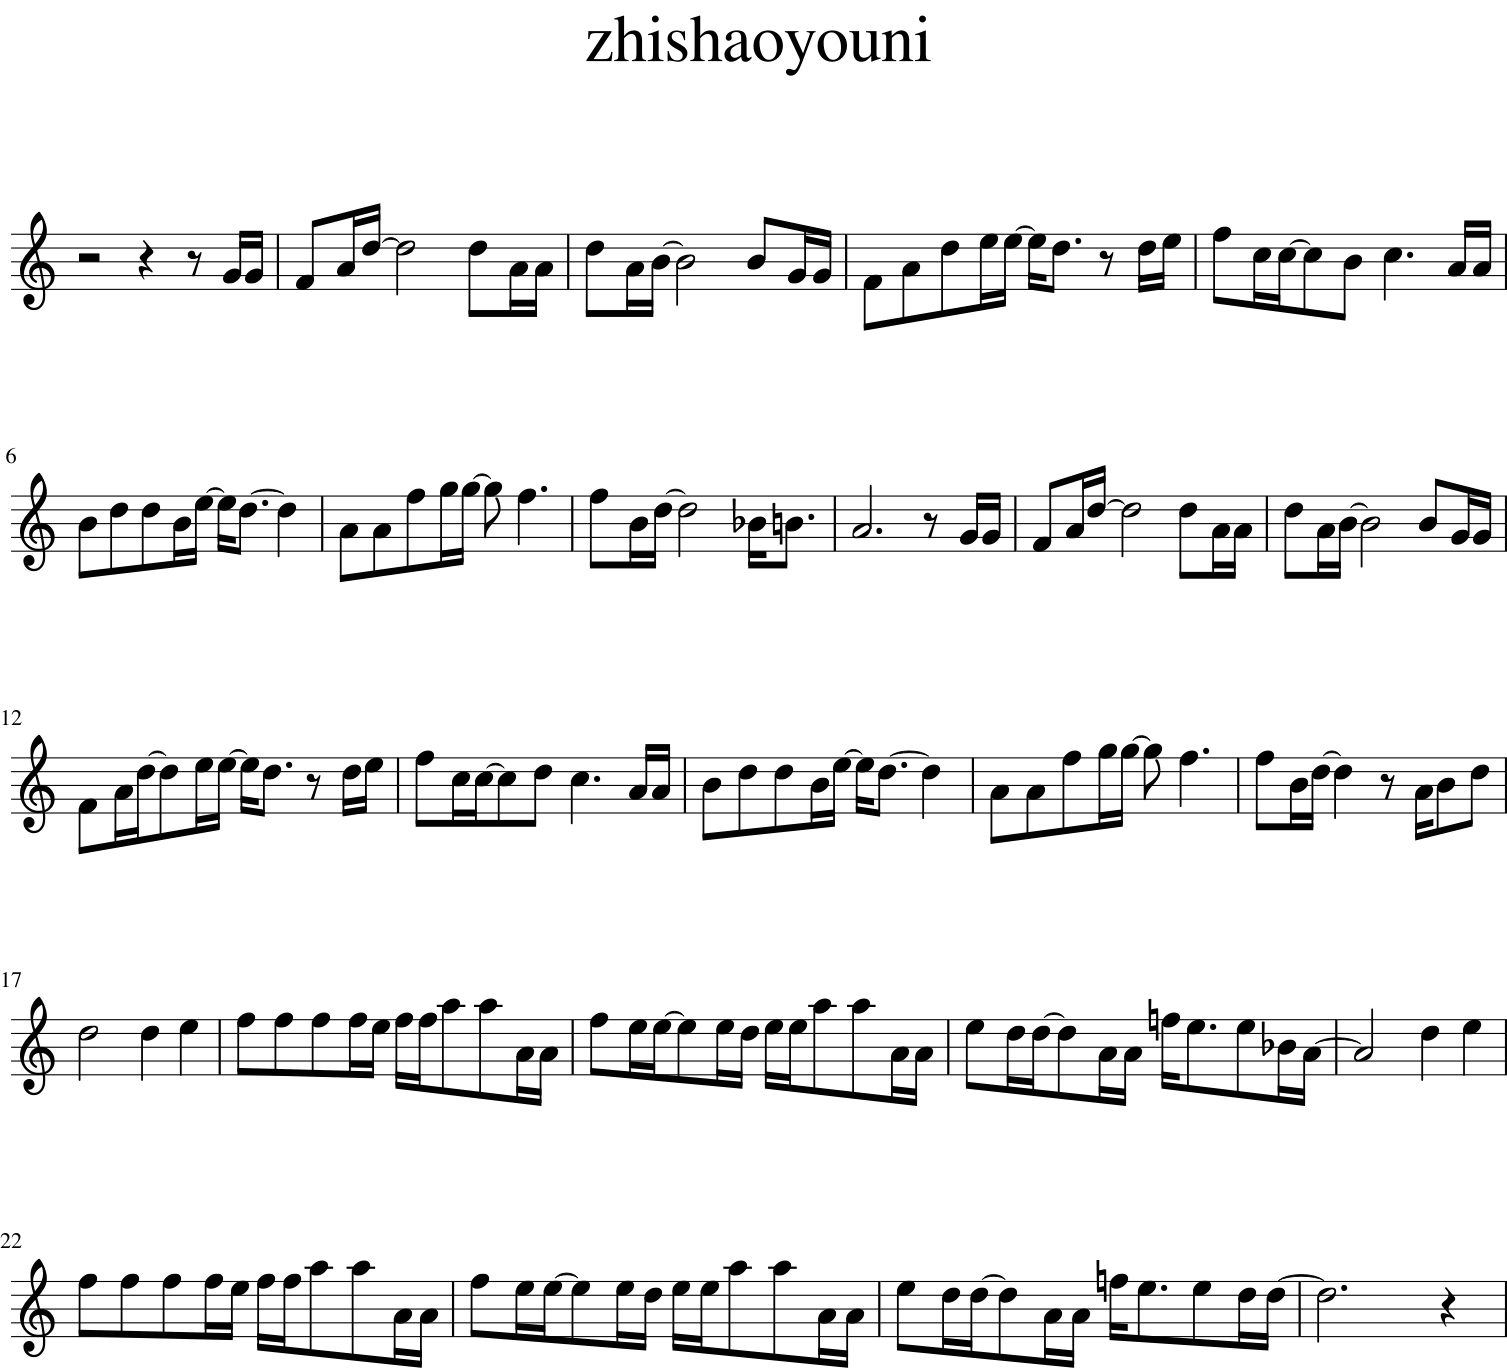

In [268]:
xml_measures = root.findall('.//measure')
measures = []

for xml_measure in xml_measures:
    measure = Measure(get_meas_notes_xml(xml_measure))
    if not measure.get_sos()==['0']:
        measures.append(measure)
        
#make parts
m21Part_main = measures_to_m21Part(measures)

#build
score = build_m21Score_1p(m21Part_main,'zhishaoyouni', ts)
score.show()

In [280]:
dirpath = '../../MIDIs/'
filename = 'jinglebells2.xml'
filepath = dirpath +filename
score.write('midi', fp=filepath)

'../../MIDIs/jinglebells2.xml'

In [270]:
score.write("midi", filepath)

'../../MIDIs/jinglebells2.mid'

In [281]:
score.write("xml", filepath)

'/home/eva/Documents/Masters/Ai and Music/FinalProject/MIDIs/jinglebells2.xml'

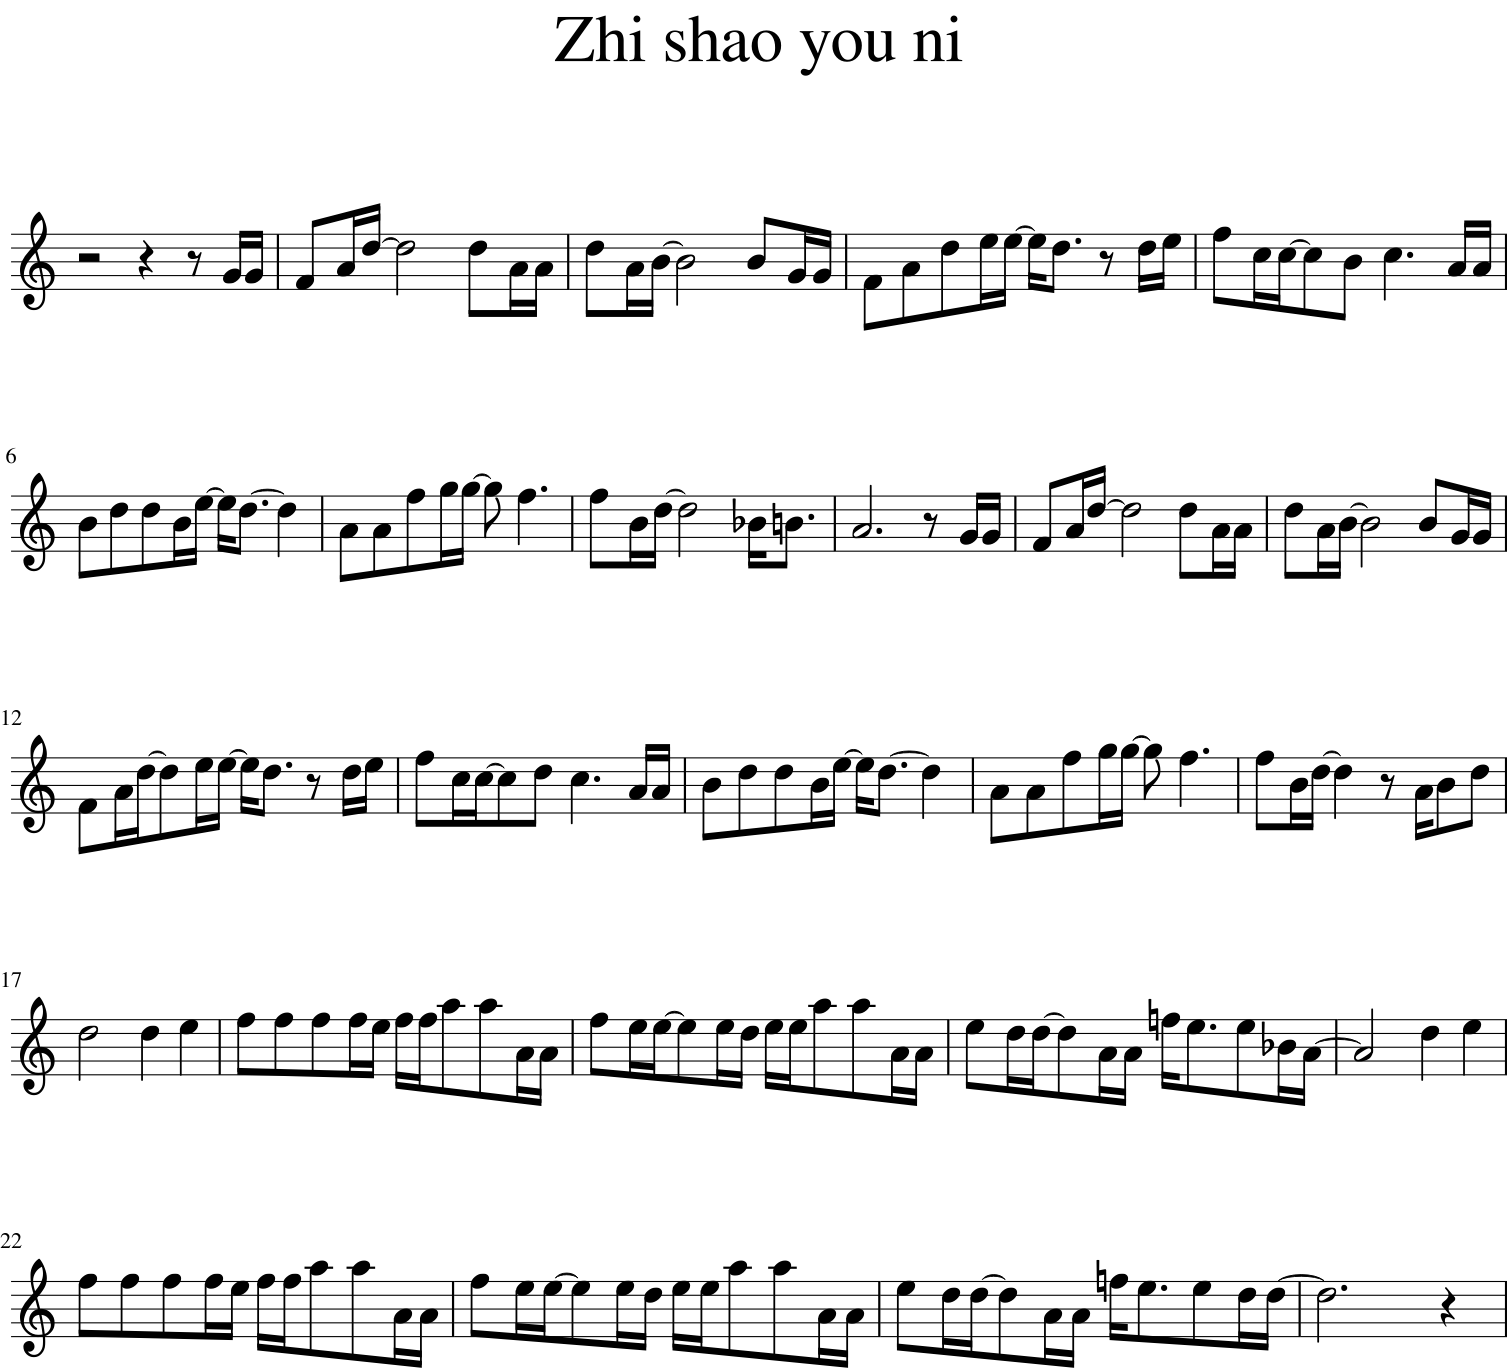

In [277]:
top,bottom = get_ts_xml(root)
ts = meter.TimeSignature(str(top)+'/'+str(bottom))
measures_to_m21Part(measures,ts)
score = build_m21Score_1p(m21Part_main,'Zhi shao you ni',ts)
score.show()

In [278]:
GEX = musicxml.m21ToXml.GeneralObjectExporter(p)
out = GEX.fromScore(score) 

In [262]:
dirpath = '../../MIDIs/'
filename = 'zhishaoyouni.mid'
filepath = dirpath +filename
score.write('midi', fp=filepath)

'../../MIDIs/zhishaoyouni.mid'

In [274]:
a = stream.Measure()
a.timeSignature = meter.TimeSignature('2/4')
a.timeSignature.numerator, a.timeSignature.denominator

(2, 4)

In [282]:
key = score.analyze('key')
print(key.tonic.name, key.mode)

D minor
